# CSCI E-81 Machine Learning and Data Mining: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Team: Nirmal Labh, Anmol Joshi**<br>
**Due Date: ** Saturday, October 29th, 2016 at 11:59pm

---
Importing python modules:
---------

Importing all python modules used in this assignment.

---

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range
import random

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

import pickle

import psutil
import platform
import math
import time
from datetime import datetime, timedelta


---
Compute Platform Spec:
---------

Made use of ** Amazon EC2 ** machine to help in getting better/largr processing power.
Machine spec: ** m4.16xlarge (64 cores, 256 GB memor) **

---

In [2]:
# printing out the compute spec of the machine in use
print('AWS EC2 Machine Details:\n')
print('  OS Version: ')
for i in (0 ,2, 3):
    print('     ', platform.uname()[i])
print('\n  CPU Count: ', '\n     ', psutil.cpu_count())
print('\n  RAM Available: ', '\n     ', int(psutil.virtual_memory()[0]/math.pow(2,30)), 'GB')

AWS EC2 Machine Details:

  OS Version: 
      Linux
      4.4.19-29.55.amzn1.x86_64
      #1 SMP Mon Aug 29 23:29:40 UTC 2016

  CPU Count:  
      64

  RAM Available:  
      251 GB


---
1. Downloading the CIFAR-10 data set:
---------

The images are available from https://www.cs.toronto.edu/~kriz/cifar.html. This data set contains 60000 32x32 color images with 10 different labeled classes. It is divided into 50000 training and 10000 test images. All training and tuning must be performed with this training set. All testing will be performed on this test set. This means that you may not include any additional training data sets and you may not ever train/tune on your test set.

---

---
Extract and read CIFAR-10 Data:
---------

We read all of the 5 batches of training data abd label data, then merge it into one consolidated set,
preserving the original order.

---

In [3]:
def unpickle(file):
    fd = open(file, 'rb')
    dict = pickle.load(fd, encoding='latin1')
    fd.close()
    return dict

p1b = unpickle('cifar-10-batches-py/data_batch_1')
p2b = unpickle('cifar-10-batches-py/data_batch_2')
p3b = unpickle('cifar-10-batches-py/data_batch_3')
p4b = unpickle('cifar-10-batches-py/data_batch_4')
p5b = unpickle('cifar-10-batches-py/data_batch_5')


p1 = {}
p1['filenames'] = 'all'
p1['batch_label'] = 'all labels'

p1['data'] = np.concatenate((p1b['data'], p2b['data'], p3b['data'], p4b['data'], p5b['data']),  axis=0)
p1['labels'] = np.concatenate((p1b['labels'], p2b['labels'], p3b['labels'], p4b['labels'], p5b['labels']),  axis=0)

test_data = unpickle('cifar-10-batches-py/test_batch')
labels = unpickle('cifar-10-batches-py/batches.meta')['label_names']

---
Inspecting and Visualizing CIFAR-10 Data:
---------

We can use matplotlib image to visualize the images. First we check the first two rows of the training dataset and labels. 

Once we print out the first two rows, 
We randomly select 10 rows from one of the dataset for literal vizualization of the image using matplotlib.

---

Data file batch number:
     all labels

Keys in the data:
     ['data', 'labels', 'batch_label', 'filenames']

# of rows in the batch:  50000
# of rows in the test data:  10000

First two rows of data:
     Image data length: 3072
     Image data: [ 59  43  50 ..., 140  84  72]
     Label index: 6
     Label name: frog

     Image data length: 3072
     Image data: [154 126 105 ..., 139 142 144]
     Label index: 9
     Label name: truck


10 random images:


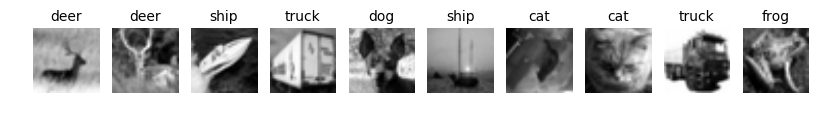

In [4]:
# print details of the data
print('Data file batch number:\n     %s\n' % (p1['batch_label']))
print('Keys in the data:\n     %s\n' % ([key for key in p1.keys()]))

print('# of rows in the batch: ', len(p1['data']))
print('# of rows in the test data: ', len(test_data['data']))
print('\nFirst two rows of data:')
for i in range(2):
    print('     Image data length: %d\n     Image data: %s\n     Label index: %d\n     Label name: %s\n'
           % (len(p1['data'][i]), p1['data'][i], p1['labels'][i], labels[p1['labels'][i]]))

    
# color channel weights, R, G, B weights based on reference url below:
#     https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/
rgb_wt = [0.299, 0.587, 0.114]

num_channels = 3
image_size = 32

# validate some of the data using direct vizualization of the images
print('\n10 random images:')

fig1 = plt.figure(figsize=(10,14))

for ii in range(10):
    jj = np.random.choice(range(len(p1['data'])))
    img = np.zeros((32,32))
    for k in range(3):
        img_data = np.array(p1['data'][jj], dtype=np.float32).reshape(-1, num_channels, 
                                                                      image_size, image_size).transpose(0,2,3,1)
        img += img_data[0,:,:,k]*rgb_wt[k] 
    imgplot1 = fig1.add_subplot(1,10,ii+1) 
    imgplot1.imshow(img, cmap=plt.get_cmap('gray')) # 'CMRmap' provides decent color pictures
    imgplot1.set_title(labels[p1['labels'][jj]], fontsize=10)
    imgplot1.axis('off')

---
2. Selecting a deep learning package:
------

As per recommendation, we are using TensorFlow.

---

In [5]:
import tensorflow as tf

---

3. Establishing baseline runs:
------

---

<font size=4>
** 3a. ** <i>Train and test a generic deep neural network on the data. Record the training time (your choice of approaches) and the accuracy on the test set.</i></font>

---

Setup the Training and Test data:
---------

Here, we are setting up the basic variables for the image size, number of labels, channels, and batch of data
we use for the test in the subsequent steps.

We are normalizing the pixel values using division by 255 to get values in range [0,1]

---

In [6]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the data - k rows of training and t rows of test data
# dividing by 255, we are normalizing the pixel data
train_dataset = np.array(p1['data'][:k], dtype=np.float32)/255.0
test_dataset = np.array(test_data['data'][:t], dtype=np.float32)/255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

---
Deep Neural Network Model: 
---------

Here, we are setting up the ** model with 3 hidden layers [1024], [1024], [512] ** for execution with and without ** dropout**.

We use the batch size of 256 and initial learning rate of 0.1, with exponential decay.

---

In [8]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

num_channels = 3
image_size = 32
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
    layer4_biases = bias_variable([10])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [9]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [10]:
test_preds = pd.DataFrame()
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()

In [11]:
time_ = []

print(time.asctime( time.localtime(time.time()) ), '- STARTING: Deep NN for full training data')
start = datetime.now()

# using the keep probability of 1, so there are no dropouts
run_session(3001, "Deep_NN", 1.0)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Deep NN for full training data')

time_difference = end - start
time_.append(time_difference.total_seconds())
time_deepnn = time_difference.total_seconds()

Tue Nov  1 16:37:53 2016 - STARTING: Deep NN for full training data
Initialized
Minibatch loss at epoch 0: 3.771559715270996
Minibatch accuracy: 12.9
Minibatch loss at epoch 500: 2.926663398742676
Minibatch accuracy: 37.5
Minibatch loss at epoch 1000: 2.712076187133789
Minibatch accuracy: 45.3
Minibatch loss at epoch 1500: 2.489379644393921
Minibatch accuracy: 52.0
Minibatch loss at epoch 2000: 2.461225986480713
Minibatch accuracy: 49.2
Minibatch loss at epoch 2500: 2.3516440391540527
Minibatch accuracy: 46.1
Minibatch loss at epoch 3000: 2.2031071186065674
Minibatch accuracy: 51.2
Test accuracy: 49.7
Tue Nov  1 16:38:59 2016 - COMPLETING: Deep NN for full training data


In [12]:
print ("Deep NN completed in %.2f seconds" % time_difference.total_seconds())

Deep NN completed in 66.38 seconds


---
<font size=4>
** 3b. ** <i>Train and test a generic convolutional network on the data. Record the training time (your choice of approaches) and the accuracy on the test set.</i></font>

---

Reshaping Training and Test Data for CNN:
---------

We are reshaping the pixel values for each image from 1x3072 to a 32x32x3 array.
This is the shape that we need for running through CNN, unlike the multinomial linear data for basic regression or basic NN.

---

In [13]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

# reshaping the image data as 32x32x3 array for CNN procesing
train_dataset = np.array(p1['data'][:k], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, 10)

test_dataset = np.array(test_data['data'][:t], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [14]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

---
Convolution Neural Network Model: 
---------

Here, we are setting up the ** model with 3 hidden layers [1024], [1024], [512] ** for execution with and without ** dropout**.

We use the batch size of 256 and initial learning rate of 0.1, with exponential decay.

---

In [15]:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return tf.matmul(full3, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [16]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   


In [17]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for full training data')
start = datetime.now()

run_session(20001, "CNN", 0.5)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for full training data')

time_difference = end - start
time_.append(time_difference.total_seconds())
time_cnn = time_difference.total_seconds()

Tue Nov  1 16:55:25 2016 - STARTING: CNN for full training data
Initialized
Minibatch loss at epoch 0: 2.321523904800415
Minibatch accuracy: 12.5
Minibatch loss at epoch 500: 1.9456779956817627
Minibatch accuracy: 25.0
Minibatch loss at epoch 1000: 1.8201590776443481
Minibatch accuracy: 37.5
Minibatch loss at epoch 1500: 0.9204263687133789
Minibatch accuracy: 68.8
Minibatch loss at epoch 2000: 1.6938698291778564
Minibatch accuracy: 31.2
Minibatch loss at epoch 2500: 1.571542739868164
Minibatch accuracy: 50.0
Minibatch loss at epoch 3000: 1.7055144309997559
Minibatch accuracy: 43.8
Minibatch loss at epoch 3500: 2.0108745098114014
Minibatch accuracy: 12.5
Minibatch loss at epoch 4000: 1.6058011054992676
Minibatch accuracy: 50.0
Minibatch loss at epoch 4500: 1.4716384410858154
Minibatch accuracy: 56.2
Minibatch loss at epoch 5000: 0.7353551387786865
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 2.482393264770508
Minibatch accuracy: 31.2
Minibatch loss at epoch 6000: 1.28699564933

In [18]:
print ("CNN completed in %.2f seconds" % time_difference.total_seconds())

CNN completed in 361.57 seconds


---
<font size=4>
** 3c. ** <i>Train and test a non-NN algorithm with reasonable performance on the data. I would suggest not SVM for speed reasons. I would suggest avoiding Naïve Bayes and Decision Tree as they generally lack accuracy, but might be worth a try as a supplement. As before, record the training time (your choice of approaches) and the accuracy on the test set.</i></font>

---

Logistic Regression Method:
---------

Not using any of the Deep Learning methods, we try to show how a method like logistic regression would perform. We will now train a simple model using the ** multinomial logistic regression classifier wth simple gradient descent ** and check the accuracy. We print out acuracy scores for the `test` datasets. This will serve somewhat as a benchmark for the performance of the subsequent Deep Learning methods we use.

---

In [19]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the training and test data - the first 1000 rows
train_dataset = np.array(p1['data'][:k], dtype=np.float32) /255.0
test_dataset = np.array(test_data['data'][:k], dtype=np.float32) /255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [20]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 50000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([(image_size*image_size*num_channels), num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [21]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (simple gradient descent) for full training data')
start = datetime.now()

num_epochs = 3001
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run() # initialize random numbers for weights and zeros for biases
    #merged = tf.merge_all_summaries()  # the next two lines are for the TensorBoard graph
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print('Initialized')
    
    for epoch in range(num_epochs): 
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (epoch % 100 == 0):
            print('Loss at epoch %d: %f' % (epoch, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    test_preds['LR_SimpleGD'] = test_prediction.eval().ravel()  

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (simple gradient descent) for full training data')

time_difference = end - start
time_.append(time_difference.total_seconds())
time_LR_SimpleGD = time_difference.total_seconds()

Tue Nov  1 17:04:37 2016 - STARTING: Logistic Regression (simple gradient descent) for full training data
Initialized
Loss at epoch 0: 33.198627
Training accuracy: 10.6%
Loss at epoch 100: 66.069633
Training accuracy: 19.5%
Loss at epoch 200: 47.535061
Training accuracy: 21.1%
Loss at epoch 300: 47.006500
Training accuracy: 22.9%
Loss at epoch 400: 62.206394
Training accuracy: 24.0%
Loss at epoch 500: 44.512585
Training accuracy: 19.2%
Loss at epoch 600: 42.024570
Training accuracy: 21.1%
Loss at epoch 700: 52.494884
Training accuracy: 21.4%
Loss at epoch 800: 46.427715
Training accuracy: 28.9%
Loss at epoch 900: 35.259521
Training accuracy: 22.1%
Loss at epoch 1000: 43.110668
Training accuracy: 19.8%
Loss at epoch 1100: 40.631130
Training accuracy: 24.8%
Loss at epoch 1200: 49.335411
Training accuracy: 22.4%
Loss at epoch 1300: 38.595020
Training accuracy: 18.8%
Loss at epoch 1400: 36.631386
Training accuracy: 27.5%
Loss at epoch 1500: 36.463806
Training accuracy: 19.3%
Loss at epoch 

In [22]:
print ("Logistic Regression completed in %.2f seconds" % time_difference.total_seconds())

Logistic Regression completed in 653.98 seconds


---   
Logistic Regression with Stochastic Gradient Descent:
------   

As we notice in subsequent execution, the stochastic gradient descent training is much faster, using batches of samples. 

---

In [23]:
batch_size = 256

graph = tf.Graph()
with graph.as_default():

    # Input data, with a placeholder to feed the training data at run time.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, (image_size*image_size*num_channels)))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([(image_size*image_size*num_channels), num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [24]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data')
start = datetime.now()
num_epochs = 3001
l_array = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #merged = tf.merge_all_summaries()  
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
    test_preds['LR_StochGD'] = test_prediction.eval().ravel() 

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data')
time_difference = end - start
time_.append(time_difference.total_seconds())
time_LR_StochGD = time_difference.total_seconds()

Tue Nov  1 17:17:58 2016 - STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data
Initialized
Minibatch loss at epoch 0: 35.016205
Minibatch accuracy: 12.5%
Test accuracy: 11.6%
Minibatch loss at epoch 500: 41.758450
Minibatch accuracy: 25.0%
Test accuracy: 19.4%
Minibatch loss at epoch 1000: 29.671572
Minibatch accuracy: 19.5%
Test accuracy: 27.7%
Minibatch loss at epoch 1500: 56.593170
Minibatch accuracy: 28.9%
Test accuracy: 27.3%
Minibatch loss at epoch 2000: 43.887566
Minibatch accuracy: 25.4%
Test accuracy: 28.3%
Minibatch loss at epoch 2500: 40.118301
Minibatch accuracy: 25.4%
Test accuracy: 26.1%
Minibatch loss at epoch 3000: 35.343224
Minibatch accuracy: 30.5%
Test accuracy: 26.8%
Tue Nov  1 17:18:07 2016 - COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data


In [25]:
print ("Logistic Regression with Stochastic Gradient Descent was completed in %.2f seconds" % time_difference.total_seconds())

Logistic Regression with Stochastic Gradient Descent was completed in 8.56 seconds


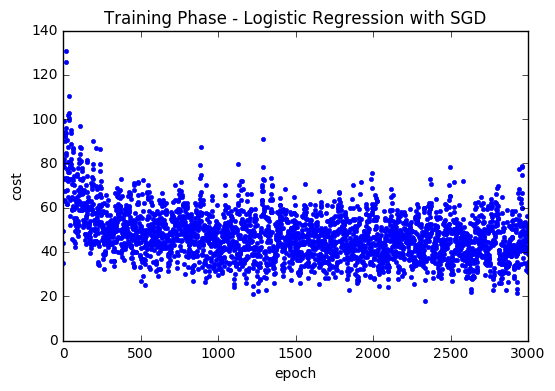

In [26]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Training Phase - Logistic Regression with SGD")
plt.show()

---
<font size=4>
** 3d. ** <i>Comment on the differences and perhaps plot the results</i>
</font>

---

In [28]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.6509803991568628, 0.4627450989392157, 0.11372549919607843)]

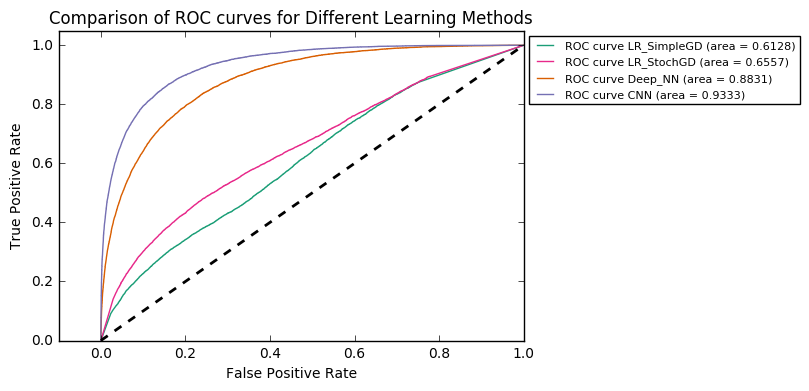

In [29]:
color=iter(cm.rainbow(np.linspace(0, 1, 3)))
classifiers = ["LR_SimpleGD", "LR_StochGD", "Deep_NN", "CNN"] 

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color=dark2_colors[i], linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC curves for Different Learning Methods')
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=8)
plt.show()

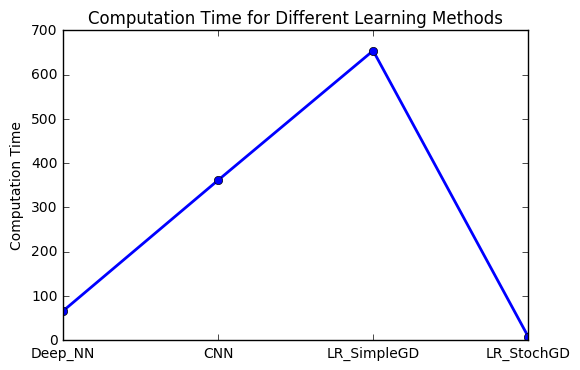

In [30]:
color=iter(cm.rainbow(np.linspace(0, 1, 4)))
classifiers = ["Deep_NN", "CNN", "LR_SimpleGD", "LR_StochGD"] 
x = range(0, 4)
# Plot all ROC curves
plt.figure()
plt.plot(x, time_, 'b-o', lw=2)
plt.xticks(x, classifiers)
plt.ylabel('Computation Time')
plt.title('Computation Time for Different Learning Methods')
plt.show()

---
4. Assess the sensitivity of the test set to training data size:
------

---
<font size=4>
** 4a. ** <i>Randomly divide the training data into at least 3 pieces (like cross-validation): A, B, C, ... but do so in a way that preserves the an equal fraction of the 10 categories of images across sets. That is, each set {A,B, etc.} should have the same number of category 1, 2,...10 images within it.</i></font>

---


In [93]:
def data_shuffle(a, a_label):
   nn = []
   for iii in range(len(a)):
       nn.append(iii)
   random.shuffle(nn)

   a1 = []
   a1_label = []
   for iii in range(len(a)):
       a1.append(a[nn[iii]])
       a1_label.append(a_label[nn[iii]])
                    
   return (a1, a1_label)

In [94]:
k = 50000

train_dataset = np.array(p1['data'][:k], dtype=np.float32) / 255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

t = 10000
test_dataset = np.array(test_data['data'][:k], dtype=np.float32) /255.0

nrows = train_dataset.shape[0]

df = []; 
A1 = []; 
B1 = []; 
C1 = []; 
A1_labels_raw = []; 
B1_labels_raw = []; 
C1_labels_raw = [];

for ii in range(0, 10):
    for j in range(0, nrows):
        if train_labels_raw[j] == ii:
            df.append(train_dataset[j, :])
    random.shuffle(df)  
          
    if len(df)%3 == 0:
        a_ = int(len(df)/3)
        b_ = 2*int(len(df)/3)
    else:
        a_ = int(round(len(df)/3))
        b_ = 2*int(round(len(df)/3))

    A1.extend(df[:a_])
    A1_labels_raw.extend([ii]*len(df[:a_]))
    (A, A_labels_raw) = data_shuffle(A1, A1_labels_raw)
    B1.extend(df[a_:b_])
    B1_labels_raw.extend([ii]*len(df[a_:b_]))
    (B, B_labels_raw) = data_shuffle(B1, B1_labels_raw)
    C1.extend(df[b_:])
    C1_labels_raw.extend([ii]*len(df[b_:]))
    (C, C_labels_raw) = data_shuffle(C1, C1_labels_raw)
    df = []
    
A = np.array(A, dtype=np.float32)
A_labels_raw = np.array(A_labels_raw)
A_labels_raw = A_labels_raw.astype(np.float32)
A_labels = (np.arange(num_labels) == A_labels_raw[:,None]).astype(np.float32).reshape(len(A_labels_raw), num_labels)

B = np.array(B, dtype=np.float32)
B_labels_raw = np.array(B_labels_raw)
B_labels_raw = B_labels_raw.astype(np.float32)
B_labels = (np.arange(num_labels) == B_labels_raw[:,None]).astype(np.float32).reshape(len(B_labels_raw), num_labels)

C = np.array(C, dtype=np.float32)
C_labels_raw = np.array(C_labels_raw)
C_labels_raw = C_labels_raw.astype(np.float32)
C_labels = (np.arange(num_labels) == C_labels_raw[:,None]).astype(np.float32).reshape(len(C_labels_raw), num_labels)


print (A.shape, A_labels.shape, B.shape, B_labels.shape, C.shape, C_labels.shape)

(16670, 3072) (16670, 10) (16670, 3072) (16670, 10) (16660, 3072) (16660, 10)


In [95]:
AB = np.concatenate((A, B), axis = 0)
AB_labels = np.concatenate((A_labels, B_labels), axis = 0)
AB_labels_raw = np.concatenate((A_labels_raw, B_labels_raw), axis = 0)

print (AB.shape, AB_labels.shape)

(33340, 3072) (33340, 10)


---
<font size=4>
** 4b ** <i>Train your classifiers in part 3 on each of the following, A, AB, etc. and test on the full test set </i>
</font>

---

---   
Deep NN for Different Training Set Sizes:
------   



---

In [96]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

In [97]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

num_channels = 3
image_size = 32
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
    layer4_biases = bias_variable([10])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [98]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [99]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (A_labels.shape[0] - batch_size)
            batch_data = A[offset:(offset + batch_size), :]
            batch_labels = A_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()


In [100]:
time_ = []

print(time.asctime( time.localtime(time.time()) ), '- STARTING: Deep NN for A')
start = datetime.now()

# using the keep probability of 1, so there are no dropouts
run_session(3001, "Deep_NN_A", 1)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Deep NN for A')

time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:17:35 2016 - STARTING: Deep NN for A
Initialized
Minibatch loss at epoch 0: 3.797725200653076
Minibatch accuracy: 9.4
Minibatch loss at epoch 500: 2.9537301063537598
Minibatch accuracy: 38.7
Minibatch loss at epoch 1000: 2.6623761653900146
Minibatch accuracy: 49.2
Minibatch loss at epoch 1500: 2.5721139907836914
Minibatch accuracy: 48.4
Minibatch loss at epoch 2000: 2.3265976905822754
Minibatch accuracy: 51.2
Minibatch loss at epoch 2500: 2.3399648666381836
Minibatch accuracy: 53.5
Minibatch loss at epoch 3000: 1.8875932693481445
Minibatch accuracy: 65.6
Test accuracy: 47.1
Tue Nov  1 19:18:41 2016 - COMPLETING: Deep NN for A
[66.431661]


In [101]:
print ("Deep NN on A was completed in %.2f seconds" % time_difference.total_seconds())

Deep NN on A was completed in 66.43 seconds


In [102]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (AB_labels.shape[0] - batch_size)
            batch_data = AB[offset:(offset + batch_size), :]
            batch_labels = AB_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()

In [103]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: Deep NN for AB')
start = datetime.now()

# using the keep probability of 1, so there are no dropouts
run_session(3001, "Deep_NN_AB", 1.0)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Deep NN for AB')

time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:18:57 2016 - STARTING: Deep NN for AB
Initialized
Minibatch loss at epoch 0: 3.758772850036621
Minibatch accuracy: 11.3
Minibatch loss at epoch 500: 2.954141616821289
Minibatch accuracy: 40.6
Minibatch loss at epoch 1000: 2.9117636680603027
Minibatch accuracy: 42.2
Minibatch loss at epoch 1500: 2.624910593032837
Minibatch accuracy: 40.6
Minibatch loss at epoch 2000: 2.5023751258850098
Minibatch accuracy: 45.7
Minibatch loss at epoch 2500: 2.281465530395508
Minibatch accuracy: 49.6
Minibatch loss at epoch 3000: 2.111759662628174
Minibatch accuracy: 56.2
Test accuracy: 46.6
Tue Nov  1 19:20:03 2016 - COMPLETING: Deep NN for AB
[66.431661, 66.241561]


In [104]:
print ("Deep NN on AB was completed in %.2f seconds" % time_difference.total_seconds())

Deep NN on AB was completed in 66.24 seconds


---   
Logistic Regression with Stochastic Gradient Descent:
------   

---

In [105]:
batch_size = 256

graph = tf.Graph()
with graph.as_default():

    # Input data, with a placeholder to feed the training data at run time.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, (image_size*image_size*num_channels)))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([(image_size*image_size*num_channels), num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [106]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data')
start = datetime.now()
num_epochs = 3001
l_array = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #merged = tf.merge_all_summaries()  
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (A_labels.shape[0] - batch_size)

        batch_data = A[offset:(offset + batch_size), :]
        batch_labels = A_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
    test_preds['A_LR_StochGD'] = test_prediction.eval().ravel() 

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data')
time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:20:21 2016 - STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data
Initialized
Minibatch loss at epoch 0: 60.063210
Minibatch accuracy: 11.7%
Test accuracy: 8.8%
Minibatch loss at epoch 500: 40.507027
Minibatch accuracy: 23.0%
Test accuracy: 26.1%
Minibatch loss at epoch 1000: 47.311657
Minibatch accuracy: 20.7%
Test accuracy: 22.4%
Minibatch loss at epoch 1500: 41.465912
Minibatch accuracy: 27.3%
Test accuracy: 23.1%
Minibatch loss at epoch 2000: 45.156498
Minibatch accuracy: 23.0%
Test accuracy: 22.5%
Minibatch loss at epoch 2500: 44.053032
Minibatch accuracy: 15.2%
Test accuracy: 24.3%
Minibatch loss at epoch 3000: 33.164845
Minibatch accuracy: 28.9%
Test accuracy: 27.5%
Tue Nov  1 19:20:30 2016 - COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data
[66.431661, 66.241561, 8.365591]


In [107]:
print ("Logistic Regression with Stochastic Gradient Descent on A was completed in %.2f seconds" % time_difference.total_seconds())

Logistic Regression with Stochastic Gradient Descent on A was completed in 8.37 seconds


In [108]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data')
start = datetime.now()
num_epochs = 3001
l_array = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #merged = tf.merge_all_summaries()  
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (AB_labels.shape[0] - batch_size)

        batch_data = AB[offset:(offset + batch_size), :]
        batch_labels = AB_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
    test_preds['AB_LR_StochGD'] = test_prediction.eval().ravel() 

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data')
time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:20:42 2016 - STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data
Initialized
Minibatch loss at epoch 0: 40.981857
Minibatch accuracy: 12.1%
Test accuracy: 9.4%
Minibatch loss at epoch 500: 48.183922
Minibatch accuracy: 18.8%
Test accuracy: 25.1%
Minibatch loss at epoch 1000: 45.585999
Minibatch accuracy: 23.8%
Test accuracy: 23.1%
Minibatch loss at epoch 1500: 43.696449
Minibatch accuracy: 20.3%
Test accuracy: 23.6%
Minibatch loss at epoch 2000: 37.372509
Minibatch accuracy: 30.9%
Test accuracy: 24.0%
Minibatch loss at epoch 2500: 31.986227
Minibatch accuracy: 35.5%
Test accuracy: 25.6%
Minibatch loss at epoch 3000: 42.667446
Minibatch accuracy: 25.8%
Test accuracy: 20.5%
Tue Nov  1 19:20:50 2016 - COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data
[66.431661, 66.241561, 8.365591, 8.533548]


In [109]:
print ("Logistic Regression with Stochastic Gradient Descent on AB was completed in %.2f seconds" % time_difference.total_seconds())

Logistic Regression with Stochastic Gradient Descent on AB was completed in 8.53 seconds


---   
CNN for Different Training Set Sizes:
------   



---

In [110]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

A_dataset = np.array(A, dtype=np.float32).reshape((-1, num_channels, image_size, image_size)).transpose(0,2,3,1)
#.reshape((-1, image_size, image_size, num_channels))

test_dataset = np.array(test_data['data'][:t], dtype=np.float32).reshape((-1, num_channels, image_size, image_size)).transpose(0,2,3,1)
#.reshape((-1, image_size, image_size, num_channels))
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', A_dataset.shape, A_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (16670, 32, 32, 3) (16670, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [111]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [112]:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return tf.matmul(full3, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [113]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (A_labels.shape[0] - batch_size)
            batch_data = A_dataset[offset:(offset + batch_size), :]   
            batch_labels = A_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   

In [114]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for A')
start = datetime.now()

# using the keep probability of 1, so there are no dropouts
run_session(20001, "CNN_A", 0.5)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for A')

time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:21:43 2016 - STARTING: CNN for A
Initialized
Minibatch loss at epoch 0: 2.3084897994995117
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 2.1032543182373047
Minibatch accuracy: 12.5
Minibatch loss at epoch 1000: 2.299384117126465
Minibatch accuracy: 12.5
Minibatch loss at epoch 1500: 1.67414391040802
Minibatch accuracy: 37.5
Minibatch loss at epoch 2000: 1.5277642011642456
Minibatch accuracy: 50.0
Minibatch loss at epoch 2500: 2.0271589756011963
Minibatch accuracy: 31.2
Minibatch loss at epoch 3000: 1.8646724224090576
Minibatch accuracy: 37.5
Minibatch loss at epoch 3500: 1.1343246698379517
Minibatch accuracy: 68.8
Minibatch loss at epoch 4000: 1.3844106197357178
Minibatch accuracy: 56.2
Minibatch loss at epoch 4500: 0.8586568832397461
Minibatch accuracy: 75.0
Minibatch loss at epoch 5000: 1.4290937185287476
Minibatch accuracy: 50.0
Minibatch loss at epoch 5500: 1.050871729850769
Minibatch accuracy: 56.2
Minibatch loss at epoch 6000: 1.0925931930541992
Minibatch acc

In [115]:
print ("CNN on A was completed in %.2f seconds" % time_difference.total_seconds())

CNN on A was completed in 360.53 seconds


In [116]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

AB_dataset = np.array(AB, dtype=np.float32).reshape((-1, num_channels, image_size, image_size)).transpose(0,2,3,1)

print('Training set', AB_dataset.shape, AB_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (33340, 32, 32, 3) (33340, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [117]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (AB_labels.shape[0] - batch_size)
            batch_data = AB_dataset[offset:(offset + batch_size), :]
            batch_labels = AB_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   

In [118]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for AB')
start = datetime.now()

# using the keep probability of 1, so there are no dropouts
run_session(20001, "CNN_AB", 1.0)

end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for AB')

time_difference = end - start
time_.append(time_difference.total_seconds())
print (time_)

Tue Nov  1 19:28:26 2016 - STARTING: CNN for AB
Initialized
Minibatch loss at epoch 0: 2.2905564308166504
Minibatch accuracy: 12.5
Minibatch loss at epoch 500: 2.0825893878936768
Minibatch accuracy: 6.2
Minibatch loss at epoch 1000: 2.1422486305236816
Minibatch accuracy: 18.8
Minibatch loss at epoch 1500: 1.7219109535217285
Minibatch accuracy: 56.2
Minibatch loss at epoch 2000: 1.882383108139038
Minibatch accuracy: 18.8
Minibatch loss at epoch 2500: 1.4071109294891357
Minibatch accuracy: 43.8
Minibatch loss at epoch 3000: 1.2727618217468262
Minibatch accuracy: 56.2
Minibatch loss at epoch 3500: 1.5810997486114502
Minibatch accuracy: 43.8
Minibatch loss at epoch 4000: 1.2511563301086426
Minibatch accuracy: 50.0
Minibatch loss at epoch 4500: 1.8115427494049072
Minibatch accuracy: 31.2
Minibatch loss at epoch 5000: 1.5592992305755615
Minibatch accuracy: 43.8
Minibatch loss at epoch 5500: 1.3148810863494873
Minibatch accuracy: 50.0
Minibatch loss at epoch 6000: 1.601201057434082
Minibatch 

In [119]:
print ("CNN on AB was completed in %.2f seconds" % time_difference.total_seconds())

CNN on AB was completed in 361.18 seconds


---
<font size=4>
** 4c ** <i>Plot and comment on how quickly the classifiers learn as compared to 3) using the full data set</i>
</font>

---

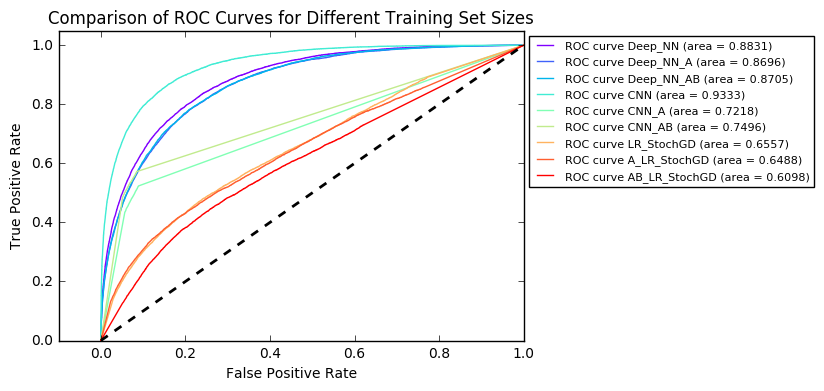

In [120]:
classifiers = ["Deep_NN", "Deep_NN_A","Deep_NN_AB", "CNN", "CNN_A", "CNN_AB", "LR_StochGD", "A_LR_StochGD", "AB_LR_StochGD"] 
color=iter(cm.rainbow(np.linspace(0,1,len(classifiers))))

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    c = next(color)
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color=c, linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for Different Training Set Sizes')
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=8)
plt.show()

In [121]:
print (time_)
time_.append(time_deepnn)
time_.append(time_cnn)
time_.append(time_LR_StochGD)
print (time_)

[66.431661, 66.241561, 8.365591, 8.533548, 360.532061, 361.180865]
[66.431661, 66.241561, 8.365591, 8.533548, 360.532061, 361.180865, 66.382733, 361.567883, 8.558985]


In [122]:
len(time_)

9

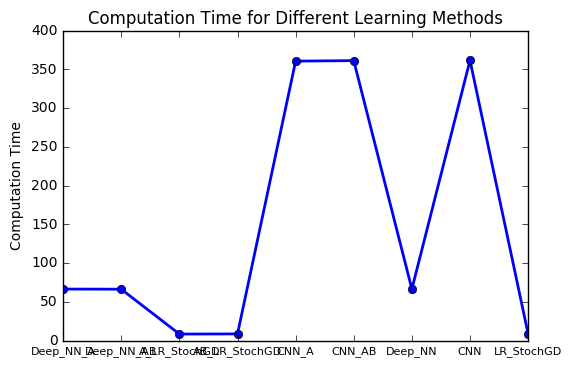

In [123]:
classifiers = ["Deep_NN_A","Deep_NN_AB", "A_LR_StochGD", "AB_LR_StochGD", "CNN_A", "CNN_AB", "Deep_NN", "CNN", "LR_StochGD"] 

x = np.array(range(0, len(time_)))
# Plot all ROC curves

plt.figure()
plt.plot(x, time_, 'b-o', lw=2)
plt.xticks(x, classifiers, fontsize = 8)
plt.ylabel('Computation Time')
plt.title('Computation Time for Different Learning Methods')
plt.show()

---
5. Assess the sensitivity of the test set to distortions:
------

---
<font size=4>
** 5a. ** <i>Create at least one additional test sets by distorting the test set in one manner (not the training
data). Possible choices include:

 * Adding random noise to the images of different levels
 * Shifting the brightness or contrast by different levels
 * Flipping or transposing the images
 * Randomly settting different fractions of the pixels to an intermediate value
 * Obscuring the top k rows of the images to an intermediate value (different levels of k)

These can be done on the fly in testing or separately. TensorFlow includes some options in their
tf.images package but similar results could be obtained using GIMP, for example.</i></font>

---


In [69]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the training and test data - the first k rows
train_dataset = np.array(p1['data'][:k], dtype=np.float32) / 255.0
test_dataset = np.array(test_data['data'][:t], dtype=np.float32) / 255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

distorted_test_dataset = 0*test_dataset

for ii in range(len(test_dataset)):
    
    img_data_ = np.array(test_dataset[ii], dtype = np.float32)
    img_data_ = img_data_.reshape(1, len(img_data_))
    img_data_ = np.rot90(img_data_)
    img_data_ = img_data_.flatten()
    distorted_test_dataset[ii] = img_data_

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', distorted_test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


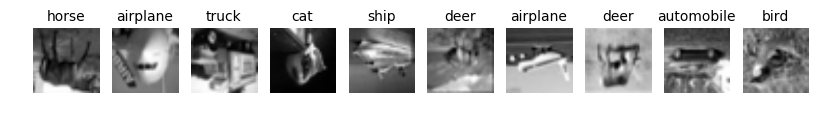

In [70]:
rgb_wt = [0.299, 0.587, 0.114]

num_channels = 3
image_size = 32
    
fig1 = plt.figure(figsize=(10,14))

for ii in range(10):
    jj = np.random.choice(range(len(distorted_test_dataset)))
    img = np.zeros((32,32))
    for k in range(3):
        img_data = np.array(distorted_test_dataset[jj], 
                            dtype=np.float32).reshape(-1, num_channels, image_size, image_size).transpose(0,2,3,1)
        img += img_data[0,:,:,k]*rgb_wt[k] 
    imgplot1 = fig1.add_subplot(1,10,ii+1) 
    imgplot1.imshow(img, cmap=plt.get_cmap('gray')) # 'CMRmap' provides decent color pictures
    imgplot1.set_title(labels[int(test_labels_raw[jj])], fontsize=10)
    imgplot1.axis('off')


---
<font size=4>
** 5b. ** <i>Repeat the baseline run analysis in 3) on the distorted images</i></font>

---


In [71]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

---
Deep Neural Network Model (repeat from problem 3): 
---------

Here, we are setting up the ** model with 3 hidden layers [1024], [1024], [512] ** for execution with and without ** dropout**.

We use the batch size of 256 and initial learning rate of 0.1, with exponential decay.

---

In [72]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

num_channels = 3
image_size = 32
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(distorted_test_dataset)

    # Variables.
    layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
    layer4_biases = bias_variable([10])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [73]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()

In [74]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: Deep NN for full training data')

# using the keep probability of 1, so there are no dropouts
run_session(3001, "Deep_NN_prob5", 1.0)

print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Deep NN for full training data')

Tue Nov  1 18:33:36 2016 - STARTING: Deep NN for full training data
Initialized
Minibatch loss at epoch 0: 3.8172659873962402
Minibatch accuracy: 9.4
Minibatch loss at epoch 500: 2.934925079345703
Minibatch accuracy: 37.1
Minibatch loss at epoch 1000: 2.6533851623535156
Minibatch accuracy: 46.9
Minibatch loss at epoch 1500: 2.513923168182373
Minibatch accuracy: 49.2
Minibatch loss at epoch 2000: 2.380491256713867
Minibatch accuracy: 52.0
Minibatch loss at epoch 2500: 2.313033103942871
Minibatch accuracy: 46.5
Minibatch loss at epoch 3000: 2.300140380859375
Minibatch accuracy: 47.7
Test accuracy: 14.5
Tue Nov  1 18:34:42 2016 - COMPLETING: Deep NN for full training data


Reshaping Training and Test Data for CNN (repeat from problem 3):
---------

We are reshaping the pixel values for each image from 1x3072 to a 32x32x3 array.
This is the shape that we need for running through CNN, unlike the multinomial linear data for basic regression or basic NN.

---

In [75]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

# reshaping the image data as 32x32x3 array for CNN procesing
train_dataset = np.array(p1['data'][:k], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, 10)

distorted_test_dataset_cnn = np.array(distorted_test_dataset[:t], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', distorted_test_dataset_cnn.shape, test_labels.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [76]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

---
Convolution Neural Network Model (repet from problem 3): 
---------

Here, we are setting up the ** model with 3 hidden layers [1024], [1024], [512] ** for execution with and without ** dropout**.

We use the batch size of 256 and initial learning rate of 0.1, with exponential decay.

---

In [77]:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(distorted_test_dataset_cnn)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return tf.matmul(full3, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [78]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   


In [79]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for full training data')

run_session(20001, "CNN_prob5", 0.5)

print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for full training data')

Tue Nov  1 18:35:24 2016 - STARTING: CNN for full training data
Initialized
Minibatch loss at epoch 0: 2.37914776802063
Minibatch accuracy: 18.8
Minibatch loss at epoch 500: 1.8891680240631104
Minibatch accuracy: 25.0
Minibatch loss at epoch 1000: 1.9181183576583862
Minibatch accuracy: 31.2
Minibatch loss at epoch 1500: 0.8459326028823853
Minibatch accuracy: 75.0
Minibatch loss at epoch 2000: 1.457381248474121
Minibatch accuracy: 31.2
Minibatch loss at epoch 2500: 1.7437992095947266
Minibatch accuracy: 31.2
Minibatch loss at epoch 3000: 1.7622134685516357
Minibatch accuracy: 31.2
Minibatch loss at epoch 3500: 2.2673916816711426
Minibatch accuracy: 18.8
Minibatch loss at epoch 4000: 1.4310245513916016
Minibatch accuracy: 31.2
Minibatch loss at epoch 4500: 1.6534979343414307
Minibatch accuracy: 37.5
Minibatch loss at epoch 5000: 0.7201251983642578
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 2.273982524871826
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 1.239074349403

Logistic Regression Method (repeat from problem 3):
---------

Not using any of the Deep Learning methods, we try to show how a method like logistic regression would perform. We will now train a simple model using the ** multinomial logistic regression classifier wth simple gradient descent ** and check the accuracy. We print out acuracy scores for the `test` datasets. This will serve somewhat as a benchmark for the performance of the subsequent Deep Learning methods we use.

---

In [80]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the training and test data - the first 1000 rows
train_dataset = np.array(p1['data'][:k], dtype=np.float32) /255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [81]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 50000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_test_dataset = tf.constant(distorted_test_dataset)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([(image_size*image_size*num_channels), num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [82]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (simple gradient descent) for full training data')
      
num_epochs = 3001
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run() # initialize random numbers for weights and zeros for biases
    #merged = tf.merge_all_summaries()  # the next two lines are for the TensorBoard graph
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print('Initialized')
    
    for epoch in range(num_epochs): 
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (epoch % 100 == 0):
            print('Loss at epoch %d: %f' % (epoch, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    test_preds['LR_SimpleGD_prob5'] = test_prediction.eval().ravel()  

print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (simple gradient descent) for full training data')

Tue Nov  1 18:53:08 2016 - STARTING: Logistic Regression (simple gradient descent) for full training data
Initialized
Loss at epoch 0: 31.557755
Training accuracy: 10.4%
Loss at epoch 100: 52.127708
Training accuracy: 17.0%
Loss at epoch 200: 58.329056
Training accuracy: 24.3%
Loss at epoch 300: 50.286491
Training accuracy: 23.0%
Loss at epoch 400: 39.670277
Training accuracy: 22.5%
Loss at epoch 500: 43.960754
Training accuracy: 23.9%
Loss at epoch 600: 50.787529
Training accuracy: 19.6%
Loss at epoch 700: 39.014534
Training accuracy: 22.0%
Loss at epoch 800: 39.096764
Training accuracy: 22.5%
Loss at epoch 900: 39.098469
Training accuracy: 24.4%
Loss at epoch 1000: 33.764904
Training accuracy: 29.9%
Loss at epoch 1100: 39.629719
Training accuracy: 25.2%
Loss at epoch 1200: 35.043282
Training accuracy: 23.4%
Loss at epoch 1300: 46.059734
Training accuracy: 27.4%
Loss at epoch 1400: 49.722599
Training accuracy: 30.2%
Loss at epoch 1500: 39.257339
Training accuracy: 27.0%
Loss at epoch 

---   
Logistic Regression with Stochastic Gradient Descent (repeat from problem 3):
------   

As we notice in subsequent execution, the stochastic gradient descent training is much faster, using batches of samples. 

---

In [83]:
batch_size = 256

graph = tf.Graph()
with graph.as_default():

    # Input data, with a placeholder to feed the training data at run time.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, (image_size*image_size*num_channels)))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(distorted_test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([(image_size*image_size*num_channels), num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [84]:
print(time.asctime( time.localtime(time.time()) ), 
      '- STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data')
num_epochs = 3001
l_array = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    #merged = tf.merge_all_summaries()  
    #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    #test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
    test_preds['LR_StochGD_prob5'] = test_prediction.eval().ravel() 

print(time.asctime( time.localtime(time.time()) ), 
      '- COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data')

Tue Nov  1 19:04:21 2016 - STARTING: Logistic Regression (Stochasric Gradient Descent)for full training data
Initialized
Minibatch loss at epoch 0: 67.395065
Minibatch accuracy: 11.7%
Test accuracy: 9.7%
Minibatch loss at epoch 500: 70.502686
Minibatch accuracy: 22.3%
Test accuracy: 5.5%
Minibatch loss at epoch 1000: 58.968559
Minibatch accuracy: 16.0%
Test accuracy: 8.1%
Minibatch loss at epoch 1500: 34.567810
Minibatch accuracy: 26.2%
Test accuracy: 9.2%
Minibatch loss at epoch 2000: 61.332924
Minibatch accuracy: 21.5%
Test accuracy: 6.6%
Minibatch loss at epoch 2500: 38.543018
Minibatch accuracy: 24.6%
Test accuracy: 11.2%
Minibatch loss at epoch 3000: 45.325550
Minibatch accuracy: 21.1%
Test accuracy: 10.5%
Tue Nov  1 19:04:29 2016 - COMPLETING: Logistic Regression (Stochasric Gradient Descent) for full training data


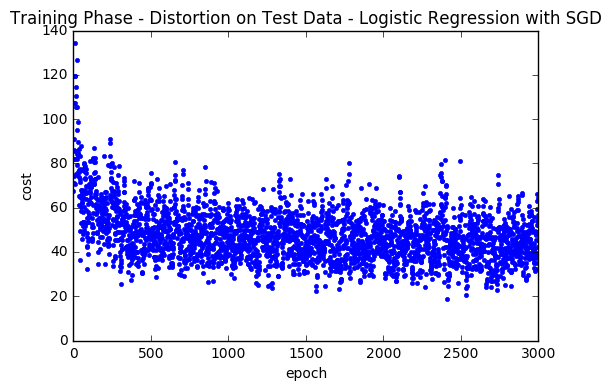

In [85]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Training Phase - Distortion on Test Data - Logistic Regression with SGD")
plt.show()

---
<font size=4>
** 5c. ** <i>Comment on what you learned</i>
</font>

---

In [86]:
# printing first 10 rows of predictions for the various models
test_preds.head(10)

,Deep_NN,CNN,LR_SimpleGD,LR_StochGD,Deep_NN_A,Deep_NN_AB,A_LR_StochGD,AB_LR_StochGD,CNN_A,CNN_AB,Deep_NN_prob5,CNN_prob5,LR_SimpleGD_prob5,LR_StochGD_prob5
0,0.048044,0.005055,8.901800e-28,2.702115e-01,0.006192,0.029548,1.006022e-09,9.781088e-01,0.000000e+00,0.000000,0.076339,0.064392,0.000000e+00,0.000000e+00
1,0.172982,0.036759,0.000000e+00,3.713609e-03,0.016972,0.022403,9.420272e-20,1.856329e-08,0.000000e+00,0.000000,0.196057,0.063352,8.410379e-16,1.553783e-02
2,0.098845,0.095143,6.734986e-12,1.699408e-20,0.095389,0.101181,8.671236e-15,0.000000e+00,0.000000e+00,0.000000,0.120295,0.151974,3.864598e-12,0.000000e+00
3,0.273398,0.698319,1.266035e-07,1.884507e-27,0.504822,0.411008,0.000000e+00,0.000000e+00,8.104463e-30,0.006866,0.375567,0.129292,1.000000e+00,1.705502e-01
4,0.059594,0.018534,3.248816e-16,2.595298e-03,0.085207,0.146662,0.000000e+00,9.997900e-06,0.000000e+00,0.000000,0.008320,0.132413,3.538287e-35,1.081622e-19
5,0.194497,0.092095,5.945899e-18,2.869603e-12,0.218629,0.199016,1.000000e+00,4.208014e-38,1.000000e+00,0.993134,0.168486,0.089100,1.006276e-30,2.532350e-17
6,0.031599,0.031596,0.000000e+00,5.502447e-25,0.017547,0.033623,1.441011e-23,2.188123e-02,0.000000e+00,0.000000,0.006053,0.228084,3.899635e-20,4.117224e-15
7,0.014186,0.005974,0.000000e+00,3.319054e-27,0.023664,0.005614,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.009193,0.069767,0.000000e+00,0.000000e+00
8,0.098139,0.004990,9.999999e-01,7.234796e-01,0.020663,0.045174,8.725481e-09,5.308599e-17,0.000000e+00,0.000000,0.023093,0.029680,4.797281e-17,8.139120e-01
9,0.008717,0.011535,0.000000e+00,5.831981e-23,0.010915,0.005770,2.684884e-36,6.492568e-21,0.000000e+00,0.000000,0.016596,0.041947,2.646544e-31,2.348759e-10


In [87]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

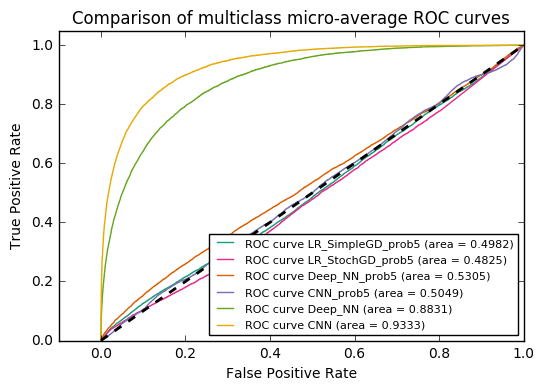

In [124]:
classifiers = ["LR_SimpleGD_prob5", "LR_StochGD_prob5", "Deep_NN_prob5", "CNN_prob5", "Deep_NN", "CNN"] 

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color=dark2_colors[i], linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of multiclass micro-average ROC curves')
plt.legend(loc="lower right", fontsize=8)
plt.show()

---
6. Compare the tuning of hyperparameters across architectural models:
------

---
<font size=4>
** 6a. ** <i>Select at least 2 architectural models where an architectural model can include:

Arragnement of Layers in a CNN, Number of Hidden Layers, Numbers of Nodes in Hidden Layers, Order of Pooling/Convolution/Etc. in CNN, and/or, CNN vs deep NN. 
</i></font>

---


We will compare CNN and Deep NN. 

<font size=4>
** 6b. ** <i>Compare the architectures in terms of speed & accuracy across >= 2 hyperparameters such as:

gradient descent optimization methods such as momentum, ADAM, Adagrad, etc., normalization effects, regularizations, droupout. 
</i></font>


The two hyperparameters we'll be comparing is Normalization and Drop Out. 

For Deep NN, we had used normalization and no dropout so we will be removing normalization and adding drop out for this test.

For CNN, we had not used normalization but used dropout so we will be adding normalization and removing droupout for this test. 

In [147]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the data - k rows of training and t rows of test data
# dividing by 255, we are normalizing the pixel data
train_dataset = np.array(p1['data'][:k], dtype=np.float32)/255.0
test_dataset = np.array(test_data['data'][:t], dtype=np.float32)/255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [148]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

num_channels = 3
image_size = 32
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
    layer4_biases = bias_variable([10])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.1
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [149]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()

In [150]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: Drop NN for full training data')
start = datetime.now()
# using the keep probability of 0.5, so we are doing dropouts
run_session(3001, "Deep_NN_with_dropout", 0.5)
end = datetime.now()
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Drop NN for full training data')

time_difference = end - start

time_dropnn = time_difference.total_seconds()

Tue Nov  1 19:58:09 2016 - STARTING: Drop NN for full training data
Initialized
Minibatch loss at epoch 0: 2.4593892097473145
Minibatch accuracy: 7.4
Minibatch loss at epoch 500: 2.229489803314209
Minibatch accuracy: 15.6
Minibatch loss at epoch 1000: 2.0312845706939697
Minibatch accuracy: 27.0
Minibatch loss at epoch 1500: 2.018226146697998
Minibatch accuracy: 32.4
Minibatch loss at epoch 2000: 1.8309963941574097
Minibatch accuracy: 42.6
Minibatch loss at epoch 2500: 1.827772855758667
Minibatch accuracy: 37.9
Minibatch loss at epoch 3000: 1.8672711849212646
Minibatch accuracy: 40.6
Test accuracy: 39.0
Tue Nov  1 19:59:16 2016 - COMPLETING: Drop NN for full training data


In [140]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the data - k rows of training and t rows of test data
# dividing by 255, we are normalizing the pixel data
train_dataset = np.array(p1['data'][:k], dtype=np.float32)
test_dataset = np.array(test_data['data'][:t], dtype=np.float32)

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [141]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

num_channels = 3
image_size = 32
num_labels = 10

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
    layer4_biases = bias_variable([10])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.25
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [142]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()

In [143]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: Drop NN for full training data')

# using the keep probability of 0.5, so we are doing dropouts
run_session(3001, "Deep_NN_nonormalization", 1.0)

print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Drop NN for full training data')

Tue Nov  1 19:55:04 2016 - STARTING: Drop NN for full training data
Initialized
Minibatch loss at epoch 0: 2.470844030380249
Minibatch accuracy: 12.5
Minibatch loss at epoch 500: nan
Minibatch accuracy: 9.8
Minibatch loss at epoch 1000: nan
Minibatch accuracy: 10.9
Minibatch loss at epoch 1500: nan
Minibatch accuracy: 9.0
Minibatch loss at epoch 2000: nan
Minibatch accuracy: 8.6
Minibatch loss at epoch 2500: nan
Minibatch accuracy: 9.4
Minibatch loss at epoch 3000: nan
Minibatch accuracy: 9.0
Test accuracy: 10.0
Tue Nov  1 19:56:10 2016 - COMPLETING: Drop NN for full training data


In [125]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

# reshaping the image data as 32x32x3 array for CNN procesing
train_dataset = np.array(p1['data'][:k], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, 10)

test_dataset = np.array(test_data['data'][:t], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [126]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [127]:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return tf.matmul(full3, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [128]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   


In [129]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for full training data')

run_session(20001, "CNN_no_dropout", 1.0)

print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for full training data')

Tue Nov  1 19:36:50 2016 - STARTING: CNN for full training data
Initialized
Minibatch loss at epoch 0: 2.2416141033172607
Minibatch accuracy: 18.8
Minibatch loss at epoch 500: 1.6649963855743408
Minibatch accuracy: 43.8
Minibatch loss at epoch 1000: 1.6144120693206787
Minibatch accuracy: 31.2
Minibatch loss at epoch 1500: 0.9590207934379578
Minibatch accuracy: 56.2
Minibatch loss at epoch 2000: 1.4744629859924316
Minibatch accuracy: 25.0
Minibatch loss at epoch 2500: 1.6499392986297607
Minibatch accuracy: 25.0
Minibatch loss at epoch 3000: 1.897667407989502
Minibatch accuracy: 31.2
Minibatch loss at epoch 3500: 1.9494075775146484
Minibatch accuracy: 12.5
Minibatch loss at epoch 4000: 1.4556413888931274
Minibatch accuracy: 37.5
Minibatch loss at epoch 4500: 1.4596757888793945
Minibatch accuracy: 43.8
Minibatch loss at epoch 5000: 0.6752755045890808
Minibatch accuracy: 81.2
Minibatch loss at epoch 5500: 2.206082820892334
Minibatch accuracy: 37.5
Minibatch loss at epoch 6000: 1.1091198921

In [130]:
# Train and test CNN on data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

# reshaping the image data as 32x32x3 array for CNN procesing
train_dataset = np.array(p1['data'][:k], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))/255.0
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, 10)

test_dataset = np.array(test_data['data'][:t], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))/255.0
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [131]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [132]:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
batch_size = 16
patch_size = 5
depth1 = 32
depth2 = 64
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_variable([depth1])
    layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
    layer2_biases = bias_variable([depth2])
    layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_variable([num_hidden])
    layer4_weights = weight_variable([num_hidden, num_labels])
    layer4_biases = bias_variable([num_labels])

    keep_prob = tf.placeholder(tf.float32)
    # Model with dropout
    def model(data, proba=keep_prob):
        # Convolution
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
        pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Convolution
        conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
        pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
        # Fully Connected Layer
        shape = pooled2.get_shape().as_list()
        reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
        full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        # Dropout
        full3 = tf.nn.dropout(full3, proba)
        return tf.matmul(full3, layer4_weights) + layer4_biases
  
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [133]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        #merged = tf.merge_all_summaries()  
        #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
                #print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        test_preds[name] = test_prediction.eval().ravel()   


In [134]:
print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN for full training data')

run_session(20001, "CNN_with_normalization", 0.5)

print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for full training data')

Tue Nov  1 19:43:15 2016 - STARTING: CNN for full training data
Initialized
Minibatch loss at epoch 0: 2.291572332382202
Minibatch accuracy: 12.5
Minibatch loss at epoch 500: 2.0137879848480225
Minibatch accuracy: 25.0
Minibatch loss at epoch 1000: 2.1984567642211914
Minibatch accuracy: 6.2
Minibatch loss at epoch 1500: 1.344254970550537
Minibatch accuracy: 56.2
Minibatch loss at epoch 2000: 1.7866703271865845
Minibatch accuracy: 18.8
Minibatch loss at epoch 2500: 1.9009121656417847
Minibatch accuracy: 12.5
Minibatch loss at epoch 3000: 1.9130568504333496
Minibatch accuracy: 31.2
Minibatch loss at epoch 3500: 1.960767388343811
Minibatch accuracy: 18.8
Minibatch loss at epoch 4000: 1.527256965637207
Minibatch accuracy: 31.2
Minibatch loss at epoch 4500: 1.6296050548553467
Minibatch accuracy: 43.8
Minibatch loss at epoch 5000: 1.1433634757995605
Minibatch accuracy: 68.8
Minibatch loss at epoch 5500: 2.1427805423736572
Minibatch accuracy: 25.0
Minibatch loss at epoch 6000: 1.2385046482086

<font size=4>
** 6c. ** <i>Plot the results and comment on what you learned. Compare the errors (or accuracy) as a function of epoch.  
</i></font>

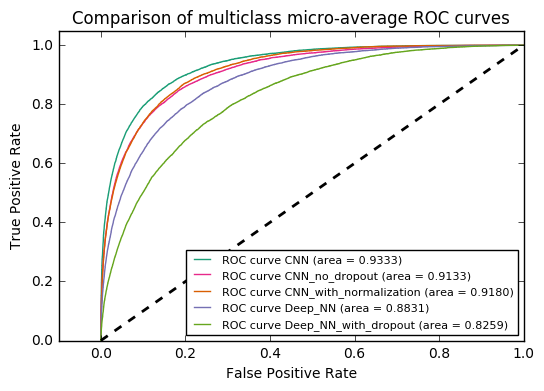

In [152]:
classifiers = ["CNN", "CNN_no_dropout", "CNN_with_normalization", "Deep_NN", "Deep_NN_with_dropout"] 

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color=dark2_colors[i], linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of multiclass micro-average ROC curves')
plt.legend(loc="lower right", fontsize=8)
plt.show()

In [153]:
test_preds.head(10)

,Deep_NN,CNN,LR_SimpleGD,LR_StochGD,Deep_NN_A,Deep_NN_AB,A_LR_StochGD,AB_LR_StochGD,CNN_A,CNN_AB,Deep_NN_prob5,CNN_prob5,LR_SimpleGD_prob5,LR_StochGD_prob5,CNN_no_dropout,CNN_with_normalization,Deep_NN_nonormalization,Deep_NN_with_dropout
0,0.048044,0.005055,8.901800e-28,2.702115e-01,0.014519,0.017209,9.817535e-01,1.000000e+00,0.0,0.0,0.076339,0.064392,0.000000e+00,0.000000e+00,0.014903,0.054569,NaN,0.076772
1,0.172982,0.036759,0.000000e+00,3.713609e-03,0.064062,0.030382,3.014127e-07,2.050605e-17,0.0,0.0,0.196057,0.063352,8.410379e-16,1.553783e-02,0.016812,0.244539,NaN,0.131870
2,0.098845,0.095143,6.734986e-12,1.699408e-20,0.068217,0.052101,8.437967e-17,3.319665e-22,0.0,0.0,0.120295,0.151974,3.864598e-12,0.000000e+00,0.205359,0.107651,NaN,0.082107
3,0.273398,0.698319,1.266035e-07,1.884507e-27,0.522778,0.595528,6.619993e-13,7.690648e-22,0.0,1.0,0.375567,0.129292,1.000000e+00,1.705502e-01,0.357811,0.207964,NaN,0.249898
4,0.059594,0.018534,3.248816e-16,2.595298e-03,0.115898,0.056782,8.303748e-08,1.504647e-22,0.0,0.0,0.008320,0.132413,3.538287e-35,1.081622e-19,0.021578,0.024567,NaN,0.044682
5,0.194497,0.092095,5.945899e-18,2.869603e-12,0.164391,0.136212,1.659068e-20,0.000000e+00,1.0,0.0,0.168486,0.089100,1.006276e-30,2.532350e-17,0.139967,0.074690,NaN,0.180589
6,0.031599,0.031596,0.000000e+00,5.502447e-25,0.026043,0.060353,1.824608e-02,5.870519e-08,0.0,0.0,0.006053,0.228084,3.899635e-20,4.117224e-15,0.017042,0.077926,NaN,0.076337
7,0.014186,0.005974,0.000000e+00,3.319054e-27,0.001487,0.002648,1.068364e-26,0.000000e+00,0.0,0.0,0.009193,0.069767,0.000000e+00,0.000000e+00,0.000564,0.003670,NaN,0.024523
8,0.098139,0.004990,9.999999e-01,7.234796e-01,0.017781,0.046463,0.000000e+00,0.000000e+00,0.0,0.0,0.023093,0.029680,4.797281e-17,8.139120e-01,0.225268,0.173720,NaN,0.090316
9,0.008717,0.011535,0.000000e+00,5.831981e-23,0.004825,0.002323,1.923080e-17,4.946293e-34,0.0,0.0,0.016596,0.041947,2.646544e-31,2.348759e-10,0.000695,0.030704,NaN,0.042906


---
7. Maximize your performance with your deep neural network or the CNN:
------

---
<font size=4>
** 7a. ** <i>Tune the parameters:</i></font>

---


### Parameter Choices for CNN:
There are many choices for parameters for tuning. We have chosen below few:
* convolution kernel dimensions: the patch size
* batch size
* number of hidden nodes
* with and wthout dropout of hidden nodes


In [154]:
# Read train and test data:
image_size = 32
num_labels = 10
num_channels = 3 # rgb channels

k = 50000
t = 10000

# reshaping the image data as 32x32x3 array for CNN procesing
train_dataset = np.array(p1['data'][:k], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, 10)

test_dataset = np.array(test_data['data'][:t], dtype=np.float32).reshape((-1, image_size, image_size, num_channels))
test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, 10)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 32, 32, 3) (50000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [155]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [156]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [157]:
optml_test_preds = pd.DataFrame()

image_size = 32
num_labels = 10
num_channels = 3 # rgb channels
depth1 = 32
depth2 = 64

graph = tf.Graph()

num_epochs = 1001
saved_roc_auc = 0
saved_name = 'None'

# iterate thru' combination of various parameters for dropout, batch size, 
# patch size and number of hidden nodes to find the best combination
for k_prob in [0.5, 1.0]:
 for batch_size in [16,32]:
  for patch_size in [5,10]:
   for num_hidden in [1024, 2048]:
    
    if k_prob < 1:
       name = 'CNN_b' + str(batch_size) + '_p' + str(patch_size) + '_n' + str(num_hidden) + '_drpYes'
    else:
       name = 'CNN_b' + str(batch_size) + '_p' + str(patch_size) + '_n' + str(num_hidden) + '_dropNo'

    print(time.asctime( time.localtime(time.time()) ), '- STARTING: CNN <' + name + '> for full training data')



    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset)

        print('batch: ', batch_size)
   
        # Variables.
        layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth1])
        layer1_biases = bias_variable([depth1])
        layer2_weights = weight_variable([patch_size, patch_size, depth1, depth2])
        layer2_biases = bias_variable([depth2])
        layer3_weights = weight_variable([image_size // 4 * image_size // 4 * depth2, num_hidden])
        layer3_biases = bias_variable([num_hidden])
        layer4_weights = weight_variable([num_hidden, num_labels])
        layer4_biases = bias_variable([num_labels])
    

        keep_prob = tf.placeholder(tf.float32)
        # Model with dropout
        def model(data, proba=keep_prob):
            # Convolution
            conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases
            pooled1 = tf.nn.max_pool(tf.nn.relu(conv1), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Convolution
            conv2 = tf.nn.conv2d(pooled1, layer2_weights, [1, 1, 1, 1], padding='SAME') + layer2_biases
            pooled2 = tf.nn.max_pool(tf.nn.relu(conv2), ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
            # Fully Connected Layer
            shape = pooled2.get_shape().as_list()
            reshape = tf.reshape(pooled2, [shape[0], shape[1] * shape[2] * shape[3]])
            full3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
            # Dropout
            full3 = tf.nn.dropout(full3, proba)
            return tf.matmul(full3, layer4_weights) + layer4_biases
  
        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

        # Predictions for the training and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

    # Re-define the function to include the keep probability
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
        optml_test_preds[name] = test_prediction.eval().ravel()   

        # saving off the best prediction
        fpr, tpr, _ = roc_curve(test_labels.ravel(), test_prediction.eval().ravel())
        roc_auc = auc(fpr, tpr)
        if saved_roc_auc < roc_auc:
           saved_roc_auc = roc_auc
           saved_name = name
           saved_test_prediction = test_prediction.eval()
            
    print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: CNN for full training data')


Tue Nov  1 20:01:08 2016 - STARTING: CNN <CNN_b16_p5_n1024_drpYes> for full training data
batch:  16
Initialized
Minibatch loss at epoch 0: 2.542827844619751
Minibatch accuracy: 6.2
Minibatch loss at epoch 500: 1.8787726163864136
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.8824067115783691
Minibatch accuracy: 18.8
Test accuracy: 45.6
Tue Nov  1 20:01:37 2016 - COMPLETING: CNN for full training data
Tue Nov  1 20:01:37 2016 - STARTING: CNN <CNN_b16_p5_n2048_drpYes> for full training data
batch:  16
Initialized
Minibatch loss at epoch 0: 2.468508005142212
Minibatch accuracy: 0.0
Minibatch loss at epoch 500: 1.7930309772491455
Minibatch accuracy: 31.2
Minibatch loss at epoch 1000: 1.6771132946014404
Minibatch accuracy: 31.2
Test accuracy: 44.3
Tue Nov  1 20:02:10 2016 - COMPLETING: CNN for full training data
Tue Nov  1 20:02:10 2016 - STARTING: CNN <CNN_b16_p10_n1024_drpYes> for full training data
batch:  16
Initialized
Minibatch loss at epoch 0: 2.330190896987915
Minibatch a

---
<font size=4>
** 7b. ** <i>Discover what works best and walk us through what you tried:</i></font>

---

Iterated through the combination of a variety of parameters, such as:
* dropout
* batch size
* number of hidden nodes
* patch size


In [158]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.6509803991568628, 0.4627450989392157, 0.11372549919607843)]


NOTE: ROC Curves have been split into two plots to avoid crouded display:


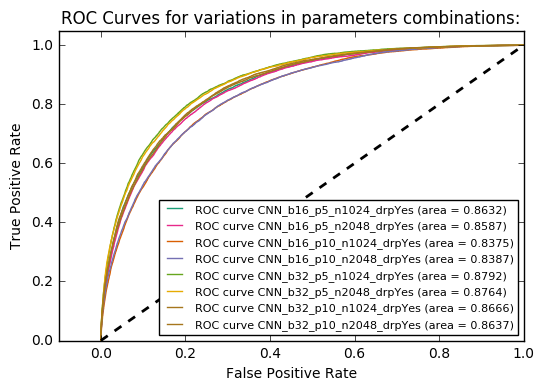

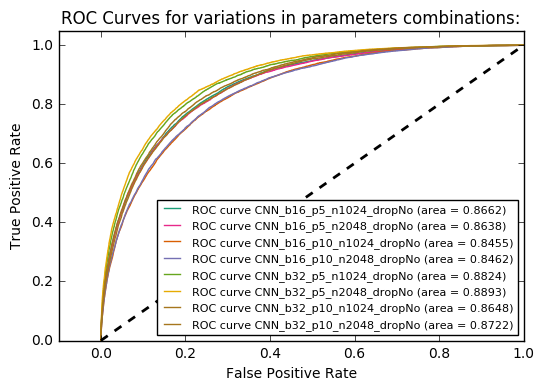

In [159]:
# so as to avoid crowding the plot, displaying in groups of 8

print('\nNOTE: ROC Curves have been split into two plots to avoid crouded display:')
for ii_end in [8,16]:
    ii_start = ii_end - 8
    classifiers = list(optml_test_preds)[ii_start:ii_end]

    # Plot all ROC curves
    plt.figure()
    for i, clf in zip(range(len(classifiers)), classifiers): 
        fpr, tpr, _ = roc_curve(test_labels.ravel(), optml_test_preds[clf] )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                       ''.format(roc_auc),
                 color=dark2_colors[i], linestyle='-', linewidth=1)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for variations in parameters combinations:')
    plt.legend(loc="lower right", fontsize=8)
    plt.show()

---
<font size=4>
** 7c. ** <i>Submit the performance as a %accuracy and as a 10x10 table in the format showing the
counts of the test images actual vs. predicted.</i></font>

---

Trying to find the best combination, in repeated runs we found the below parameters yielded predictions higher test accuracy and with largest roc:
* Model:  ** CNN **
* Batch Size:  ** 32 **
* Patch Size:  ** 5 **
* number of hiden nodes:  ** 2048 **
* Dropout used:  ** No **

ROC:  ** 0.8878 **

Test accuracy: ** 49.7 **


In [161]:
# best parameters, roc and test accuracy:

# expected format - CNN_b<nn>_p<n>_n<nnnn>_drop<Yes|No>
model,batch,patch,hidden_nodes,dropout = saved_name.split('_')

batch = batch.replace('b', '')
patch = patch.replace('p', '')
hidden_nodes = hidden_nodes.replace('n', '')
dropout = dropout.replace('drop', '')

# displaying the best parameters, roc and test accuracy
print('Model: ', model)
print('Batch Size: ', batch)
print('Patch Size: ', patch)
print('# of hiden nodes: ', hidden_nodes)
print('Dropout used: ', dropout)

print('\nROC: ', saved_roc_auc.round(4))
print("Test accuracy: {:.1f}%".format(accuracy(saved_test_prediction, test_labels)))

# grouping and summing up for the predictions that were found to be optimal
df_preds = pd.DataFrame(saved_test_prediction)
df_preds.columns = ['Predicted1', 'Predicted2', 'Predicted3', 'Predicted4', 'Predicted5',
                    'Predicted6', 'Predicted7', 'Predicted8', 'Predicted9', 'Predicted10']
df_preds.loc[:, 'Labels'] = test_labels_raw

df_sum = df_preds.groupby('Labels').sum()

df_pred_agg = df_sum.round().astype(int).reset_index(level=0)

df_pred_agg.Labels.replace([0,1,2,3,4,5,6,7,8,9], 
                           ['Actual1','Actual2','Actual3','Actual4','Actual5',
                            'Actual6','Actual7','Actual8','Actual9','Actual10'], inplace=True)

df_pred_agg.set_index(['Labels'], inplace=True)

df_pred_agg.head(10)

Model:  CNN
Batch Size:  32
Patch Size:  5
# of hiden nodes:  2048
Dropout used:  No

ROC:  0.8893
Test accuracy: 49.9%


,Predicted1,Predicted2,Predicted3,Predicted4,Predicted5,Predicted6,Predicted7,Predicted8,Predicted9,Predicted10
Labels,,,,,,,,,,
Actual1,353,34,87,39,92,32,45,29,205,85
Actual2,75,271,35,53,37,37,70,33,111,278
Actual3,75,14,221,118,185,133,127,55,40,32
Actual4,34,19,102,268,82,197,157,59,32,50
Actual5,56,14,143,93,301,101,150,75,41,27
Actual6,25,10,112,223,90,307,108,70,28,25
Actual7,22,17,89,124,110,96,453,34,20,35
Actual8,43,19,83,105,147,121,75,326,24,57
Actual9,140,55,32,37,53,24,31,18,488,123


---
Exploratory Points:
------

---
<font size=4>

</i></font>

---

In [162]:
image_size = 32
num_labels = 10
num_channels = 3 # grayscale

k = 50000
t = 10000

# Get a subset of the data - k rows of training and t rows of test data
# dividing by 255, we are normalizing the pixel data
train_dataset = np.array(p1['data'][:k], dtype=np.float32)/255.0
test_dataset = np.array(test_data['data'][:t], dtype=np.float32)/255.0

# Transforming the labels into one-hot-encoded matrices with 10 columns,
# or, in other words, mapping 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
train_labels_raw = np.array(p1['labels'][:k], dtype=np.float32)
train_labels = (np.arange(num_labels) == train_labels_raw[:,None]).astype(np.float32).reshape(k, num_labels)

test_labels_raw = np.array(test_data['labels'][:t], dtype=np.float32)
test_labels = (np.arange(num_labels) == test_labels_raw[:,None]).astype(np.float32).reshape(t, num_labels)

# display the shapes for confirming the data setup
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 3072) (50000, 10)
Test set (10000, 3072) (10000, 10)


In [163]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

In [164]:
start_time = []
end_time = []
Run_Sessions_Deep_NN = []
Run_Sessions_Drop_NN = []
drop_time_ = []
deepnn_time_ = []

print(time.asctime( time.localtime(time.time()) ), '- STARTING: Deep and Drop NN for reduced training data')

for ii in range(3, 33):
    pca = PCA(n_components=(ii**2))
    pca.fit(train_dataset)
    train_reduced = pca.transform(train_dataset)
    train_reduced = np.array(train_reduced, dtype=np.float32)
    test_reduced = pca.transform(test_dataset)
    test_reduced = np.array(test_reduced, dtype=np.float32)
    batch_size = 256
    hidden_nodes = (ii**2)
    lamb_reg = 0.001

    num_channels = 1
    image_size = ii
    num_labels = 10

    graph = tf.Graph()
    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size*num_channels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_test_dataset = tf.constant(test_reduced)

        # Variables.
        layer1_weights = weight_variable([image_size*image_size*num_channels, hidden_nodes])
        layer1_biases = bias_variable([hidden_nodes])
        layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
        layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
        layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
        layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
        layer4_weights = weight_variable([split_by_half(hidden_nodes,2), 10])
        layer4_biases = bias_variable([10])

        keep_prob = tf.placeholder("float")

        # Model with dropout
        def model(data, proba=keep_prob):
            layer1 = tf.matmul(data, layer1_weights) + layer1_biases
            hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
            layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
            hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
            layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
            hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
            return tf.matmul(hidden3, layer4_weights) + layer4_biases

        # Training computation.
        logits = model(tf_train_dataset, keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
        regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                        tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                        tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                        tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

        # Add the regularization term to the loss.
        #loss += lamb_reg * regularizers
        loss = tf.reduce_mean(loss + lamb_reg * regularizers)

        # Optimizer.
        # learning rate decay
        global_step = tf.Variable(0)  # count  number of steps taken.
        start_learning_rate = 0.1
        learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))
    def run_session(num_epochs, name, k_prob=1.0):

        with tf.Session(graph=graph) as session:
            #merged = tf.merge_all_summaries()  
            #writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
            tf.initialize_all_variables().run()
            print("Initialized")
            for epoch in range(num_epochs):
                offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
                batch_data = train_reduced[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]
                feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
                _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
                if (epoch % 500 == 0):
                    print("Minibatch loss at epoch {}: {}".format(epoch, l))
                    print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
            print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels)))
            test_preds[name] = test_prediction.eval().ravel()
    
    # using the keep probability of 1, so there are no dropouts
    Run_Session_Index_Deep_NN = "Deep_NN_explore_" + str(ii)
    Run_Session_Index_Drop_NN = "Drop_NN_explore_" + str(ii)
    Run_Sessions_Deep_NN.append(Run_Session_Index_Deep_NN)
    Run_Sessions_Drop_NN.append(Run_Session_Index_Drop_NN)
    start = datetime.now()
    run_session(3001, Run_Session_Index_Deep_NN, 1.0);
    end = datetime.now()
    time_difference = end - start
    deepnn_time_.append(time_difference.total_seconds())
    start = datetime.now()
    run_session(3001, Run_Session_Index_Drop_NN, 0.5);
    end = datetime.now()
    time_difference = end - start
    drop_time_.append(time_difference.total_seconds())
print(time.asctime( time.localtime(time.time()) ), '- COMPLETING: Deep and Drop NN for reduced training data')

Run_Sessions_Deep_NN.append("Deep_NN")
deepnn_time_.append(time_deepnn)
Run_Sessions_Drop_NN.append("Deep_NN_with_dropout")
drop_time_.append(time_dropnn)

Tue Nov  1 20:28:17 2016 - STARTING: Deep and Drop NN for reduced training data
Initialized
Minibatch loss at epoch 0: 5.1977691650390625
Minibatch accuracy: 8.2
Minibatch loss at epoch 500: 2.300703287124634
Minibatch accuracy: 11.7
Minibatch loss at epoch 1000: 2.261809825897217
Minibatch accuracy: 11.3
Minibatch loss at epoch 1500: 2.170433521270752
Minibatch accuracy: 17.6
Minibatch loss at epoch 2000: 2.097191572189331
Minibatch accuracy: 19.1
Minibatch loss at epoch 2500: 2.0527279376983643
Minibatch accuracy: 22.3
Minibatch loss at epoch 3000: 1.9816292524337769
Minibatch accuracy: 27.3
Test accuracy: 25.0
Initialized
Minibatch loss at epoch 0: 4.903449535369873
Minibatch accuracy: 7.8
Minibatch loss at epoch 500: 2.3187806606292725
Minibatch accuracy: 9.0
Minibatch loss at epoch 1000: 2.3183109760284424
Minibatch accuracy: 7.4
Minibatch loss at epoch 1500: 2.315807819366455
Minibatch accuracy: 10.5
Minibatch loss at epoch 2000: 2.315463066101074
Minibatch accuracy: 8.6
Minibatc

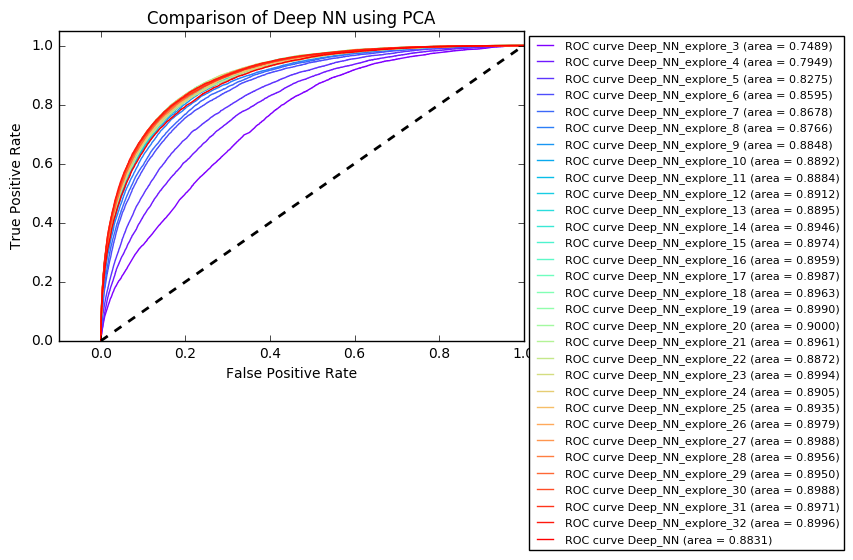

In [165]:
color=iter(cm.rainbow(np.linspace(0,1,len(Run_Sessions_Deep_NN))))

classifiers = Run_Sessions_Deep_NN

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    c=next(color)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color= c, linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Deep NN using PCA')
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=8)
plt.show()

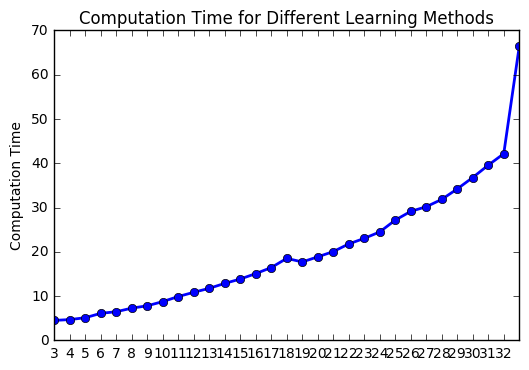

In [168]:
color=iter(cm.rainbow(np.linspace(0,1,len(Run_Sessions_Deep_NN))))

classifiers = Run_Sessions_Deep_NN


x = range(0, len(Run_Sessions_Deep_NN))
# Plot all ROC curves
plt.figure()
plt.plot(x, deepnn_time_, 'b-o', lw=2)
plt.xticks(x, range(3, 33))
plt.ylabel('Computation Time')
plt.title('Computation Time for Different Learning Methods')
plt.show()

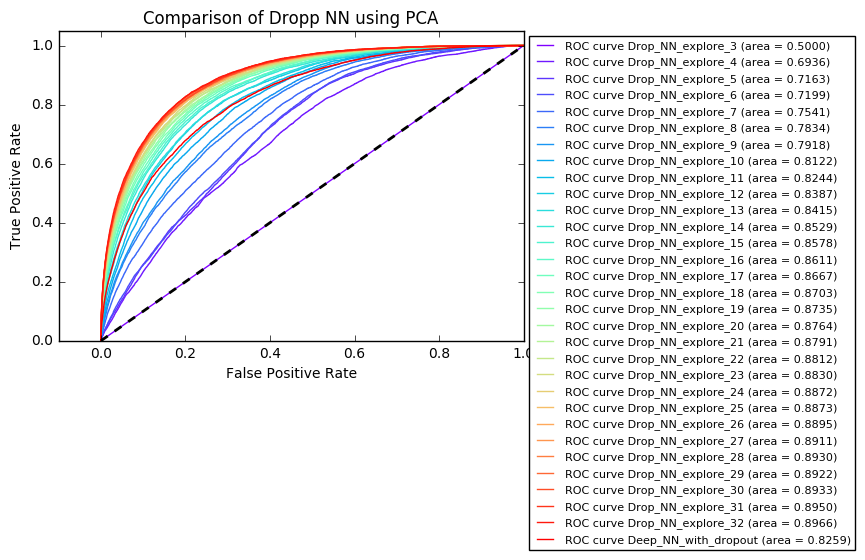

In [172]:
color=iter(cm.rainbow(np.linspace(0,1,len(Run_Sessions_Drop_NN))))

classifiers = Run_Sessions_Drop_NN

# Plot all ROC curves
plt.figure()
for i, clf in zip(range(len(classifiers)), classifiers): 
    fpr, tpr, _ = roc_curve(test_labels.ravel(), test_preds[clf] )
    c=next(color)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label='ROC curve '+ clf +  ' (area = {0:0.4f})'
                   ''.format(roc_auc),
             color= c, linestyle='-', linewidth=1)


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Dropp NN using PCA')
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=8)
plt.show()

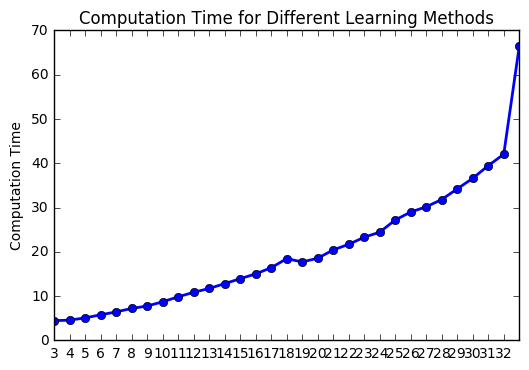

In [174]:
color=iter(cm.rainbow(np.linspace(0,1,len(Run_Sessions_Drop_NN))))

classifiers = Run_Sessions_Drop_NN


x = range(0, len(Run_Sessions_Drop_NN))
# Plot all ROC curves
plt.figure()
plt.plot(x, drop_time_, 'b-o', lw=2)
plt.xticks(x, range(3, 33))
plt.ylabel('Computation Time')
plt.title('Computation Time for Different Learning Methods')
plt.show()